In [1]:
import pandas as pd 

In [2]:
dataset = pd.read_csv(r"C:\Users\Satyajeet\blood.csv")
dataset

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,99,1
1,0,13,3250,28,1
2,1,17,4000,36,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


In [3]:
dataset.isnull().sum()

Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64

In [4]:
dataset.columns

Index(['Recency', 'Frequency', 'Monetary', 'Time', 'Class'], dtype='object')

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support


In [6]:
dataset.head()
dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


,Recency,Frequency,Monetary,Time,Class
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.516043,1378.676471,34.284759,0.237968
std,8.095396,5.841825,1459.826781,24.380307,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,99.000000,1.000000


In [ ]:
# Convert Time to datetime if needed
if 'Time' in dataset.columns:
    try:
        dataset['Time'] = pd.to_datetime(dataset['Time'])
    except Exception as e:
        print("Time parse error:", e)

# Ensure numeric columns
for col in ['Recency','Frequency','Monetary']:
    if col in dataset.columns:
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce')


Class
0    0.762032
1    0.237968
Name: proportion, dtype: float64


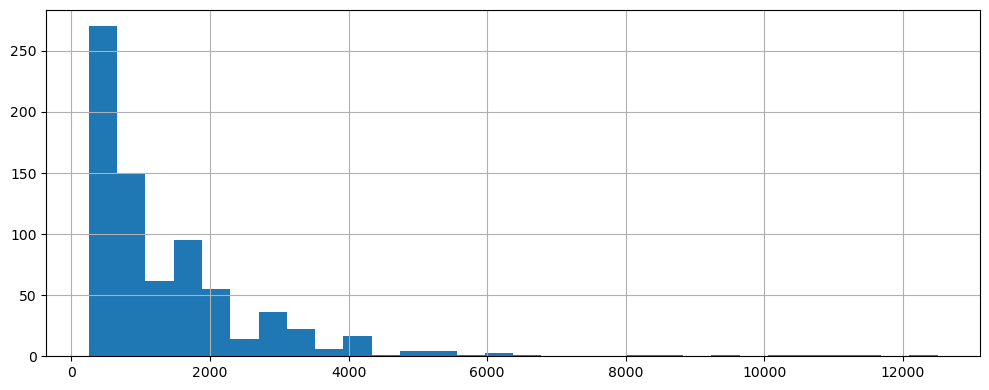

In [ ]:
dataset[col].hist(bins=30, figsize=(10,4))
plt.tight_layout()

# Check distribution of Class
if 'Class' in dataset.columns:
    print(dataset['Class'].value_counts(normalize=True))


In [ ]:
# Example: if Recency is days since last check, Frequency is counts, Monetary is some score

# Create log transforms to reduce skew
for col in ['Frequency','Monetary']:
    if col in dataset.columns:
        dataset[f'{col}_log'] = np.log1p(dataset[col])

# If Time present, create recency in days from last timestamp in dataset
if 'Time' in dataset.columns:
    max_time = dataset['Time'].max()
    dataset['days_since'] = (max_time - dataset['Time']).dt.days
    # rolling/seasonality example: month, weekday
    dataset['month'] = dataset['Time'].dt.month
    dataset['weekday'] = dataset['Time'].dt.weekday


In [ ]:
# RFM scoring (example 1-5 score each, higher -> better)
def r_score(x, bins):
    return pd.cut(x, bins=bins, labels=range(len(bins)-1,0,-1))  # reverse so recent=high

# Example bins — tune based on data distribution
dataset['R_score'] = pd.qcut(dataset['Recency'], q=4, labels=[4,3,2,1]).astype(int)  # smaller Recency -> better, so reverse if needed
dataset['F_score'] = pd.qcut(dataset['Frequency'], q=4, labels=[1,2,3,4]).astype(int)
dataset['M_score'] = pd.qcut(dataset['Monetary'], q=4, labels=[1,2,3,4]).astype(int)

dataset['RFM_sum'] = dataset['R_score'] + dataset['F_score'] + dataset['M_score']


In [ ]:
# prepared features & target
target = 'Class' if 'Class' in dataset.columns else None

# If no Class, you can create one using RFM thresholds (example below)
if target is None:
    dataset['Class'] = np.where(dataset['RFM_sum'] >= 10, 'low-risk', 'high-risk')
    target = 'Class'

X = dataset.drop(columns=[target])
y = dataset[target]

# Select a subset of columns for model
feature_cols = ['Recency','Frequency','Monetary','days_since','R_score','F_score','M_score']
feature_cols = [c for c in feature_cols if c in X.columns]

X = X[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Build pipeline with scaling + classifier
num_features = X_train.columns.tolist()
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features)
])

clf = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC (if binary):", roc_auc_score(pd.get_dummies(y_test).iloc[:,1], pd.get_dummies(y_pred).iloc[:,1]) if len(y.unique())==2 else "multi-class or single-class")


              precision    recall  f1-score   support

           0       0.82      0.94      0.88       114
           1       0.65      0.36      0.46        36

    accuracy                           0.80       150
   macro avg       0.74      0.65      0.67       150
weighted avg       0.78      0.80      0.78       150

ROC AUC (if binary): 0.6498538011695907


In [ ]:
#  compare baseline models
from sklearn.model_selection import cross_validate
models = {
    'logreg': Pipeline([('pre', preprocessor), ('m', LogisticRegression(max_iter=1000))]),
    'rf': Pipeline([('pre', preprocessor), ('m', RandomForestClassifier(n_estimators=200))])
}

for name, model in models.items():
    scores = cross_validate(model, X, y, cv=5, scoring=['accuracy','f1_macro'])
    print(name, np.mean(scores['test_accuracy']), np.mean(scores['test_f1_macro']))


logreg 0.7540581655480985 0.52343916207812
rf 0.7286174496644294 0.5606916345023649


In [ ]:
# grid search
param_grid = {
    'model__n_estimators':[100,300],
    'model__max_depth':[None,10,20],
}
pipe = Pipeline([('pre', preprocessor), ('model', RandomForestClassifier(random_state=42))])
gs = GridSearchCV(pipe, param_grid, cv=4, scoring='f1_macro', n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_params_)
print(classification_report(y_test, gs.predict(X_test)))


{'model__max_depth': 10, 'model__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       114
           1       0.65      0.36      0.46        36

    accuracy                           0.80       150
   macro avg       0.74      0.65      0.67       150
weighted avg       0.78      0.80      0.78       150



In [ ]:
# User input prediction

import numpy as np

def user_prediction(model, preprocessor):
    print("Enter details to predict health status:\n")
    
    recency = 2
    frequency = 50
    monetary =12500
    
    # Optional time-based feature
    try:
        time_days = 99
    except:
        time_days = 0
    
    # Create dataframe
    user_df = pd.DataFrame([{
        'Recency': recency,
        'Frequency': frequency,
        'Monetary': monetary,
        'days_since': time_days
    }])
    
    # Recreate feature engineering steps (log transforms and RFM scores if used)
    for col in ['Frequency','Monetary']:
        user_df[f'{col}_log'] = np.log1p(user_df[col])
    
    # Add RFM scores based on training quantiles (approximate example)
    try:
        user_df['R_score'] = pd.cut(user_df['Recency'], bins=np.quantile(df['Recency'], q=[0,0.25,0.5,0.75,1]), labels=[4,3,2,1]).astype(int)
        user_df['F_score'] = pd.cut(user_df['Frequency'], bins=np.quantile(df['Frequency'], q=[0,0.25,0.5,0.75,1]), labels=[1,2,3,4]).astype(int)
        user_df['M_score'] = pd.cut(user_df['Monetary'], bins=np.quantile(df['Monetary'], q=[0,0.25,0.5,0.75,1]), labels=[1,2,3,4]).astype(int)
    except:
        user_df['R_score'] = user_df['F_score'] = user_df['M_score'] = 2
    
    user_df['RFM_sum'] = user_df['R_score'] + user_df['F_score'] + user_df['M_score']
    
    # Select model features
    feature_cols = ['Recency','Frequency','Monetary','days_since','R_score','F_score','M_score']
    feature_cols = [c for c in feature_cols if c in user_df.columns]
    X_user = user_df[feature_cols]
    
    # Preprocess
    X_user_scaled = preprocessor.transform(X_user)
    
    # Predict
    prediction = model.predict(X_user_scaled)[0]
    prob = model.predict_proba(X_user_scaled)[0][1] if hasattr(model, 'predict_proba') else None
    
    print("\n--- Prediction Result ---")
    print(f"🧠 Predicted Class: {prediction}")
    if prob is not None:
        print(f"🔹 Probability of being Class 1 (at-risk): {prob:.2f}")
    
    # Simple recommendation logic
    if prediction == 1 or (prob is not None and prob > 0.5):
        print("⚠️ Recommendation: You may be in a higher-risk group. Schedule a medical check-up or donation review soon.")
    else:
        print("✅ Recommendation: You seem to be in a low-risk / healthy group. Continue regular health monitoring.")
    
    return user_df

# Run it
user_prediction(gs.best_estimator_.named_steps['model'], gs.best_estimator_.named_steps['pre'])


Enter details to predict health status:


--- Prediction Result ---
🧠 Predicted Class: 0
🔹 Probability of being Class 1 (at-risk): 0.41
✅ Recommendation: You seem to be in a low-risk / healthy group. Continue regular health monitoring.


,Recency,Frequency,Monetary,days_since,Frequency_log,Monetary_log,R_score,F_score,M_score,RFM_sum
0,2,50,12500,99,3.931826,9.433564,2,2,2,6


In [15]:
import joblib

# Save the full pipeline (preprocessor + model)
joblib.dump(gs.best_estimator_, 'model.pkl')
print("✅ Model saved successfully as model.pkl")

✅ Model saved successfully as model.pkl
